In [1]:
# Import libraries 
#!pip install torchsummary
import torch                
import torch.nn as nn  
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import datasets, transforms  
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# 2. Loading and transforming dataset 
mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Shape of data torch.Size([64, 1, 28, 28])


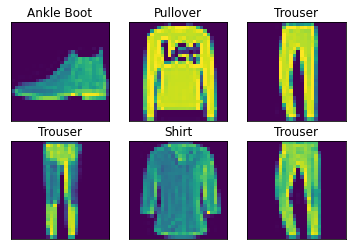

In [3]:
#3 View few images from test data 
# loading one set of test data batch 
sample = enumerate(testloader)
batch_id, (sample_data, sample_targets) = next(sample)

#shape of one test data batch 
print('Shape of data',sample_data.shape)

# FMNIST data labels 
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']


fig = plt.figure()
# Viewing 6 images from loaded test data batch
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(sample_data[i][0])
  plt.title("{}".format(FMNIST_labels[sample_targets[i]]))
  plt.xticks([])
  plt.yticks([])


In [4]:
#4 Building network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26  RF 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22 RF 7 Jout - 1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  RF 8 Jout - 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11  RF 8 Jout- 2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9  RF - 12 ,Jout - 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 RF - 16  Jout - 2

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7  RF - 16  Jout - 2 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1  RF -28  Jout - 2 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [5]:
#5 Model Summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           2,048
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 32, 9, 9]           9,216
             ReLU-11             [-1, 32, 9, 9]               0
           Conv2d-12             [-1, 32, 7, 7]           9,216
             ReLU-13             [-1, 32, 7, 7]               0
           Conv2d-14             [-1, 1

In [6]:
#6 training the network 
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1,4):
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

Loss=0.8866766691207886 Batch_id=937 Accuracy=64.75: 100%|██████████| 938/938 [02:39<00:00,  5.88it/s]
Loss=0.577509343624115 Batch_id=0 Accuracy=81.25:   0%|          | 1/938 [00:00<02:45,  5.68it/s]


Test set: Average loss: 0.6001, Accuracy: 7869/10000 (78.69%)



Loss=1.012218713760376 Batch_id=937 Accuracy=82.97: 100%|██████████| 938/938 [02:42<00:00,  5.76it/s]
Loss=0.3382517993450165 Batch_id=0 Accuracy=89.06:   0%|          | 1/938 [00:00<02:46,  5.64it/s]


Test set: Average loss: 0.4596, Accuracy: 8350/10000 (83.50%)



Loss=0.38069063425064087 Batch_id=937 Accuracy=84.66: 100%|██████████| 938/938 [02:42<00:00,  5.79it/s]



Test set: Average loss: 0.4410, Accuracy: 8482/10000 (84.82%)

